<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Inputs" data-toc-modified-id="Inputs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inputs</a></span></li><li><span><a href="#Script" data-toc-modified-id="Script-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Script</a></span></li><li><span><a href="#Sanity-check" data-toc-modified-id="Sanity-check-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sanity check</a></span><ul class="toc-item"><li><span><a href="#Difference" data-toc-modified-id="Difference-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Difference</a></span></li></ul></li></ul></div>

In [1]:
PROC = False    # <- A very long process will evaluate if this is True

import os, glob; files = glob.glob("data/*.nc"); files

['data/MCD43A1.2017.nc',
 'data/MCD43A1.2015.nc',
 'data/MCD43A1.2018.nc',
 'data/MCD43A1.2016.nc',
 'data/MCD43A3.2018.01.01.nc']

# Batch

This notebook simplifies the code from the first notebook [1_Workflow.ipynb](1_Workflow.ipynb) and presents as a script. Copy the next cell into a script and run from command line or import functions. They are fairly generic and (will) have help text.


## Inputs
These are the input arguments:

In [2]:
nc_in = files[2]
skyl_lut = "data/skyl_lut.dat"
optical_depth = "0.20"

black_out = "result/black_albedo_"+os.path.basename(nc_in)
white_out = "result/white_albedo_"+os.path.basename(nc_in)
blue_out = "result/blue_albedo_"+os.path.basename(nc_in)

nc_in, skyl_lut, optical_depth, black_out, white_out, blue_out

('data/MCD43A1.2018.nc',
 'data/skyl_lut.dat',
 '0.20',
 'result/black_albedo_MCD43A1.2018.nc',
 'result/white_albedo_MCD43A1.2018.nc',
 'result/blue_albedo_MCD43A1.2018.nc')

If you copy the next cell into `mcd43a1_calc.py`, those arguments are passed to python in shell like:

```shell
$ python mcd43a1_calc.py nc_in.nc, skyl_lut.dat, black_out.nc, white_out.nc, blue_out.nc
    
    Script: mcd43a1_calc.py
    Args:   nc_in.nc     = input MCD43A1; netCDF output from AppEEARS 
            skyl_lut.dat = sky coeff from lookup table (skyl_lut.dat) from blue albedo source code  
            black_out    = default: black_albedo_<input-netCDF>.nc
            white_out    = default: white_albedo_<input-netCDF>.nc
            blue_out     = default: blue_albedo_<input-netCDF>.nc
```

## Script

**Copy the following cell into a script to run from terminal: **

In [3]:
%matplotlib inline

## processing -->>
from pyproj import Proj, transform
from math import radians, cos
from io import StringIO
import xarray as xr   
import pandas as pd
import numpy as np
import datetime
import sys
import os

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

bands = [
    "BRDF_Albedo_Parameters_Band1",
    "BRDF_Albedo_Parameters_Band2",
    "BRDF_Albedo_Parameters_Band3",
    "BRDF_Albedo_Parameters_Band4",
    "BRDF_Albedo_Parameters_Band5",
    "BRDF_Albedo_Parameters_Band6",
    "BRDF_Albedo_Parameters_Band7",
    "BRDF_Albedo_Parameters_nir",
    "BRDF_Albedo_Parameters_shortwave",
    "BRDF_Albedo_Parameters_vis",
]

# ---------------------------------------------------------------------------- 
# coordinate + sza functions
# ----------------------------------------------------------------------------


def get_proj(crs):
    """Get srs parameters as proj4 string."""
    
    getpar = lambda a: str(crs.attrs[a])
    return(Proj(" ".join([
        "+proj=sinu",
        "+lon_0="+getpar("longitude_of_central_meridian"),
        "+x_0="+getpar("false_easting"),
        "+y_0="+getpar("false_northing"),
        "+a="+getpar("semi_major_axis"),
        "+b="+getpar("semi_minor_axis"),
        "+units="+"meter +no_defs"])))


# get lat and lon 2d arrays
def get_latlon(ds, inproj, outproj):
    """ """
    
    xx, yy = np.meshgrid(ds.x.data, ds.y.data)
    lon1d, lat1d = transform(
        inproj, 
        outproj, 
        xx.flatten(), 
        yy.flatten())
    lon2d, lat2d = lon1d.reshape(xx.shape), lat1d.reshape(yy.shape)
    
    return(xx, yy, lon1d, lat1d, lon2d, lat2d)


def get_solar_zenith(doy, latitude, ndoy=365):
    """ """
    declination = cos(radians((doy+10)*(360/ndoy)))*-23.45
    altitude = 90 - latitude + declination
    zenith = 90 - altitude
    return(zenith)


def sza_eval(doy, lat):
    """Convert CF to Python datetime."""
    func = lambda l: get_solar_zenith(doy, l)
    return(xr.apply_ufunc(func, lat))


def get_sza(ds):
    """Get xr.DataArray for SZA."""

    sza = xr.DataArray(
        data=np.dstack([sza_eval(t.dt.dayofyear, ds.lat) for t in ds.time]), 
        coords=[ds.y, ds.x, ds.time],       # note that we reorder coords in
        dims=["y", "x", "time"],            # dims argument to match others
        attrs=dict(
            units="degree",
            standard_name="solar zenith angle",
            long_name="solar zenith angle"))
    sza.name = "solar_zenith_angle"
    sza = sza.transpose("time", "y", "x")
    
    return(sza)


# ---------------------------------------------------------------------------- 
# 2d lat and lon arrays
# ----------------------------------------------------------------------------      


def get_coordinates(ds):
    """Add coordinate variables to an input dataset with 'x' and 'y' dims.
    """

    inproj = get_proj(ds.crs)
    outproj = Proj(init="epsg:4326")

    xx, yy, lon1d, lat1d, lon2d, lat2d = get_latlon(ds, inproj, outproj)

    latatts = dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north")

    ds.coords["lat"] = xr.DataArray(
        data=lat2d, 
        coords=[ds.y, ds.x], 
        dims=["y", "x"], 
        attrs=latatts)

    lonatts = dict(
        standard_name="longitude",
        long_name="longitude coordinate",
        units="degrees_east")

    ds.coords["lon"] = xr.DataArray(
        data=lon2d, 
        coords=[ds.y, ds.x], 
        dims=["y", "x"], 
        attrs=lonatts)
    
    return(ds)


# ----------------------------------------------------------------------------
# ALBEDO
# ----------------------------------------------------------------------------

albedo_attributes = dict(
    _FillValue=32767,
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    add_offset=0.0)


# black and white sky albedo -------------------------------------------------


def fBSA(param1, param2, param3, sza):
    """Black sky albedo."""
    s = np.radians(sza)                                         # to radians
    func = lambda p1, p2, p3: (
        p1*( 1.0      +  0.0     *(s**2) + 0.0     *(s**3)) +   # Isotropic
        p2*(-0.007574 + -0.070987*(s**2) + 0.307588*(s**3)) +   # RossThick
        p3*(-1.284909 + -0.166314*(s**2) + 0.041840*(s**3)))    # LiSparseR
    return(xr.apply_ufunc(func, param1, param2, param3))


def fWSA(param1, param2, param3):
    """White sky albedo."""
    func = lambda p1, p2, p3: (
        p1* 1.0       +                                         # Isotropic
        p2* 0.189184  +                                         # RossThick
        p3*-1.377622 )                                          # LiSparseR
    return(xr.apply_ufunc(func, param1, param2, param3))


# blue sky albedo ------------------------------------------------------------


def lookup(sza, luc):
    """In: zenith angle integer [0-90] and optical depth [0.00-0.98]
    Out: lookup value? ..."""    
    lfunc = lambda s: luc.iloc[s].values
    return(xr.apply_ufunc(lfunc, abs(sza).round(),))


def fALB(wsa, bsa, lookup):
    """Vectorize blue albedo formula."""
    afunc = lambda w,b,l: (w*l)+(b*(1-l))
    return(xr.apply_ufunc(afunc, wsa, bsa, lookup))


# ----------------------------------------------------------------------------
# Add each band's lookup table to the dataset as a variable attribute:
# ----------------------------------------------------------------------------

get_band_name = lambda ds:[v for v in ds.variables if all([
    "param" in ds[v].dims, v!="param"])][0]


"""
def run_albedo(ds, od="0.20"): 
    """ """
    
    band_name = get_band_name(ds)
    band = ds[band_name]
    param1 = band.sel(param=0)
    param2 = band.sel(param=1)
    param3 = band.sel(param=2)
    sza = ds["solar_zenith_angle"]
    
    bsa = fBSA(param1, param2, param3, sza)*10             #~ x10 to resolve
    bsa.name = "black_sky_albedo"                          #    mysterious 
    bsa.attrs = albedo_attributes                          #    scale offset
    bsa.attrs.update(dict(long_name="black_sky_albedo"))   #    of 0.1 - prob
                                                           #    from SZA vals
    
    wsa = fWSA(param1, param2, param3)*10                  #~ do the same for
    wsa.name = "white_sky_albedo"                          #    white sky alb
    wsa.attrs = albedo_attributes
    wsa.attrs.update(dict(long_name="white_sky_albedo"))

    luv = lookup(sza.data.flatten(), band.attrs["lut"][od]).reshape(sza.shape)
    lu = xr.DataArray(
        data=luv, 
        coords=[sza.time, sza.y, sza.x],
        dims=["time", "y", "x"],
        attrs=dict(
            units="unitless",
            long_name="lookup value"))
    
    alb = fALB(wsa, bsa, lu)
    alb.name = "blue_sky_albedo"
    alb.attrs = albedo_attributes
    alb.attrs.update(dict(long_name="blue_sky_albedo"))
    
    return(xr.Dataset({
        "blue_sky_albedo": alb, 
        "black_sky_albedo": bsa, 
        "white_sky_albedo": wsa}))
"""

""" ##########################################################################
#   EXECUTE

#   This follows the `pandas` and `xarray` *groupby: Split-Apply-Combine*:
#   http://xarray.pydata.org/en/stable/groupby.html
########################################################################## """


def main(ds, skyl_lut, optical_depth, black_out, white_out, blue_out):
    """The main function to be properly documented later.
    
    Some text description.
    
    Args:
        Arg1: Description
        Arg2: Description
        
    Returns:
        Returns this and that.
    """

    # open netcdf ------------------------------------------------------------
    print("1 ~ Reading netCDF; generating coordinate arrays ... ")

    # rename x and y dims
    ds = ds.rename({'Num_Parameters': 'param', 'xdim': 'x', 'ydim': 'y'})

    # add lat,lon coordinate arrays
    ds = get_coordinates(ds)


    # get sza arrays ---------------------------------------------------------
    print("2 ~ Calculating solar zenith angles and building arrays ... ")
    
    ds["solar_zenith_angle"] = ds.groupby('time.month').apply(get_sza)

    for output in [black_out, white_out, blue_out]:
        ds[["lat", "lon", "solar_zenith_angle", "crs"]].to_netcdf(
            output, 
            mode="w", 
            unlimited_dims=["time"],
            encoding={
                "lat": dict(zlib=True, complevel=5),
                "lon": dict(zlib=True, complevel=5),
                "solar_zenith_angle": dict(zlib=True, complevel=5)})


    # add lookup table (pandas.DataFrame) as attribute -----------------------
    print("3 ~ Generating lookup value arrays ... ")

    with open(skyl_lut, "r") as f:
        tab = f.read().replace("  ", " ")
    con, mar = [t.split("Band") for t in tab.split("Aerosol_type: ")[1:]]

    get_lut = lambda s: pd.read_csv(
        StringIO(s),
        index_col="S&O",
        skiprows=1,
        sep=" ")

    for i, band in enumerate(bands):
        ds[band].attrs.update({"lut": get_lut(con[i+1])})


    # loop over bands --------------------------------------------------------
    print("4 ~ Calculating albedos bandwise ... \n")

    for i, band in enumerate(bands):
        print("\t["+str(i+1)+"/"+str(len(bands))+"]\t--- Processing: "+band) 

        # select band; parameters --------------------------------------------
        
        band_parameters = ds[band]
        par1 = band_parameters.sel(param=0)
        par2 = band_parameters.sel(param=1)
        par3 = band_parameters.sel(param=2)
        sza = ds["solar_zenith_angle"]
        
        # black sky albedo ---------------------------------------------------
        
        bsa = fBSA(par1, par2, par3, sza)
        bsa.name = band
        bsa.attrs = albedo_attributes
        bsa.attrs["long_name"] = "black_sky_albedo"
      
        # white sky albedo ---------------------------------------------------
    
        wsa = fWSA(par1, par2, par3)
        wsa.name = band
        wsa.attrs = albedo_attributes
        wsa.attrs["long_name"] = "white_sky_albedo"
        
        # blue sky albedo ----------------------------------------------------
        
        luv = lookup(
            sza.data.flatten(), 
            band_parameters.attrs["lut"][optical_depth]
        ).reshape(sza.shape)
        
        lu = xr.DataArray(
            data=luv, 
            coords=[sza.time, sza.y, sza.x],
            dims=["time", "y", "x"],
            attrs=dict(units="unitless", long_name="lookup value"))

        alb = fALB(wsa, bsa, lu)
        alb.name = band
        alb.attrs = albedo_attributes
        alb.attrs["long_name"] = "blue_sky_albedo"

        # write outputs ------------------------------------------------------
        
        # arguments for netcdf writing
        arg_out = dict(mode="a", unlimited_dims=["time"])
        enc_out = lambda n: {n: dict(zlib=True, complevel=5)}
        
        # append to outputs
        bsa.to_netcdf(black_out, encoding=enc_out(band),**arg_out)
        wsa.to_netcdf(white_out, encoding=enc_out(band),**arg_out)
        alb.to_netcdf(blue_out, encoding=enc_out(band),**arg_out)
        
        
##############################################################################
# DON'T COPY THIS PART >>>
from IPython.display import clear_output

if PROC:                                           # boolean initiates eval
    
    ds = xr.open_dataset(nc_in)                    # read header; 
    for group in ds.groupby("time.month"):         # iterate over months
        clear_output()                             # clear cell output
        mon, dat = group                           # get group number and data
        print(78*"-"+"\nMonth:\t"+str(mon)+"\n")   # print an update
        
        # call main; compute black, white, blue sky albedo; write outputs
        
        main(dat,                                  # dat is a 1 month slice
             skyl_lut,                             # lookup tab for skyl coeff
             optical_depth,                        # optical depth input
             black_out[:-3]+"_"+str(mon)+".nc",    # outputs for black,
             white_out[:-3]+"_"+str(mon)+".nc",    #   white, and
             blue_out[:-3]+"_"+str(mon)+".nc")     #   blue albedos

else:

    print("Processing flag is set to False. Skipping albedo calculation.")

Processing flag is set to False. Skipping albedo calculation.


## Sanity check
List the output netCDFs that were just written to the `result/` directory:

In [4]:
final = sorted(glob.glob("result/*.nc")); final

['result/black_albedo_MCD43A1.2018_1.nc',
 'result/black_albedo_MCD43A1.2018_10.nc',
 'result/black_albedo_MCD43A1.2018_11.nc',
 'result/black_albedo_MCD43A1.2018_12.nc',
 'result/black_albedo_MCD43A1.2018_2.nc',
 'result/black_albedo_MCD43A1.2018_3.nc',
 'result/black_albedo_MCD43A1.2018_4.nc',
 'result/black_albedo_MCD43A1.2018_5.nc',
 'result/black_albedo_MCD43A1.2018_6.nc',
 'result/black_albedo_MCD43A1.2018_7.nc',
 'result/black_albedo_MCD43A1.2018_8.nc',
 'result/black_albedo_MCD43A1.2018_9.nc',
 'result/blue_albedo_MCD43A1.2018_1.nc',
 'result/blue_albedo_MCD43A1.2018_10.nc',
 'result/blue_albedo_MCD43A1.2018_11.nc',
 'result/blue_albedo_MCD43A1.2018_12.nc',
 'result/blue_albedo_MCD43A1.2018_2.nc',
 'result/blue_albedo_MCD43A1.2018_3.nc',
 'result/blue_albedo_MCD43A1.2018_4.nc',
 'result/blue_albedo_MCD43A1.2018_5.nc',
 'result/blue_albedo_MCD43A1.2018_6.nc',
 'result/blue_albedo_MCD43A1.2018_7.nc',
 'result/blue_albedo_MCD43A1.2018_8.nc',
 'result/blue_albedo_MCD43A1.2018_9.nc'

That's a lot of outputs. I kept getting Python kernel failures when trying to write to a single output netCDF. Took a little bit of trial and error. That's on a PC with 128GB of RAM and 32 cores also. So don't expect this script to run out of the box on a consumer-grade desktop. 

So, we have `12(Months) * 3(Albedos) == 36` output netCDFs.    

**Do a visual inspection of black sky albedo for January 1 2018.** 

Compare the black sky albedo that we calculated from MCD43A1 against the black sky albedo distributed with the MCD43A3 product (for Band 1):

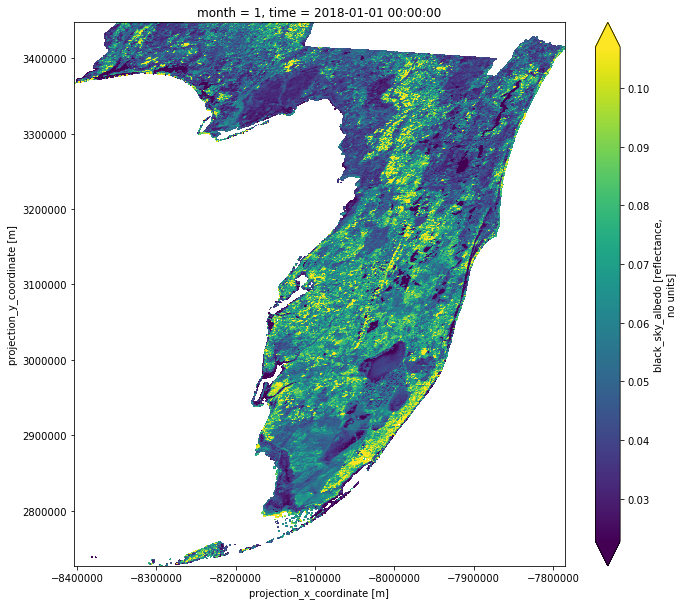

In [5]:
%matplotlib inline
ds = xr.open_dataset(final[0])
ds["BRDF_Albedo_Parameters_Band1"][0].plot(x="x", y="y", robust=True, figsize=(11,10))

Get a list of files in the input data directory:

In [6]:
datafiles = glob.glob("data/*.nc")
datafiles

['data/MCD43A1.2017.nc',
 'data/MCD43A1.2015.nc',
 'data/MCD43A1.2018.nc',
 'data/MCD43A1.2016.nc',
 'data/MCD43A3.2018.01.01.nc']

An **MCD43A3** dataset should be in there somewhere. If not, download one for Florida 2018 through AppEEARS. Select it and open, printing the header:

In [7]:
check = xr.open_dataset(datafiles[4])
check

<xarray.Dataset>
Dimensions:                                       (time: 1, xdim: 1336, ydim: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00
  * ydim                                          (ydim) float64 3.447e+06 ... 2.727e+06
  * xdim                                          (xdim) float64 -8.404e+06 ... -7.785e+06
Data variables:
    crs                                           int8 ...
    Albedo_BSA_Band1                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band2                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band3                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band4                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band5                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band6                              (time, ydim, xdim) float32 ...
    Albedo_BSA_Band7                              (time, ydim

Select **black sky albedo for January 1, 2018 for Band 1 of the MCD43A3 dataset** and plot the grid:

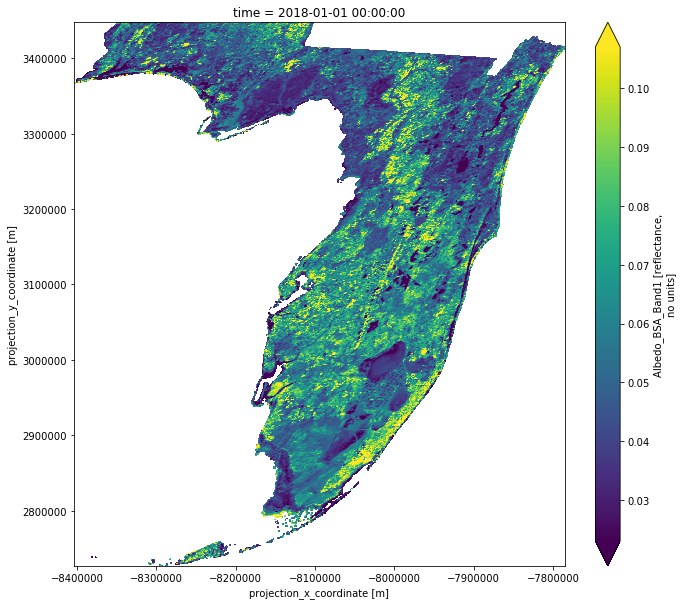

In [8]:
b1 = check["Albedo_BSA_Band1"]                      # select black for band 1
mcd43a3 = b1[0].rename({'xdim': 'x', 'ydim': 'y'})  # rename dims (required)

mcd43a3.plot(x="x", y="y", robust=True, figsize=(11,10))   # plot

Select the black sky albedo that we computed above for the same date and band and print the headers for both (MCD43A1 and MCD43A3):

In [9]:
mcd43a1 = ds["BRDF_Albedo_Parameters_Band1"][0]

# all string formatting stuff ---->>>>
hdr = str("\n".join(["-"*78, "\t"*4+"{prod}", "-"*78]))
print("\n"+hdr.format(prod="MCD43A1")+"\n"); print(mcd43a1); 
print("\n"+hdr.format(prod="MCD43A3")+"\n"); print(mcd43a3)


------------------------------------------------------------------------------
				MCD43A1
------------------------------------------------------------------------------

<xarray.DataArray 'BRDF_Albedo_Parameters_Band1' (y: 1555, x: 1336)>
[2077480 values with dtype=float64]
Coordinates:
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
    month    int64 ...
    time     object 2018-01-01 00:00:00
  * x        (x) float64 -8.404e+06 -8.403e+06 ... -7.786e+06 -7.785e+06
  * y        (y) float64 3.447e+06 3.447e+06 3.446e+06 ... 2.728e+06 2.727e+06
Attributes:
    grid_mapping:      crs
    valid_min:         0
    valid_max:         32766
    units:             reflectance, no units
    scale_factor_err:  0.0
    add_offset_err:    0.0
    calibrated_nt:     5
    long_name:         black_sky_albedo

------------------------------------------------------------------------------
				MCD43A3
------------------------------------------------------------------------------

<x

### Difference
Subtract the black sky albedo from MCD43A3 from our computed black sky albedo (MCD43A1) to see if we did everything right. Plot:

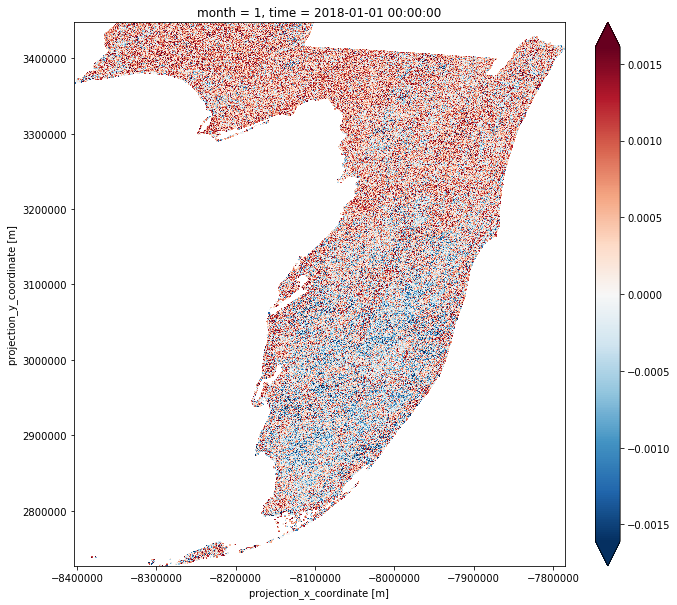

In [10]:
diff = (mcd43a1-mcd43a3)
diff.plot(x="x", y="y", robust=True, figsize=(11,10))

Very similar. Check the histogram (**y-axis is logged**):

(array([     1.,      0.,      0.,      0.,      0.,      0.,      1.,
             0.,      0.,      0.,      0.,      1.,      3.,     18.,
           144.,   4080.,  96732., 359175., 231624.,  15346.]),
 array([-0.01890111, -0.01782274, -0.01674437, -0.015666  , -0.01458763,
        -0.01350926, -0.01243089, -0.01135252, -0.01027415, -0.00919578,
        -0.00811741, -0.00703904, -0.00596067, -0.0048823 , -0.00380393,
        -0.00272556, -0.00164718, -0.00056881,  0.00050956,  0.00158793,
         0.0026663 ]),
 <a list of 20 Patch objects>)

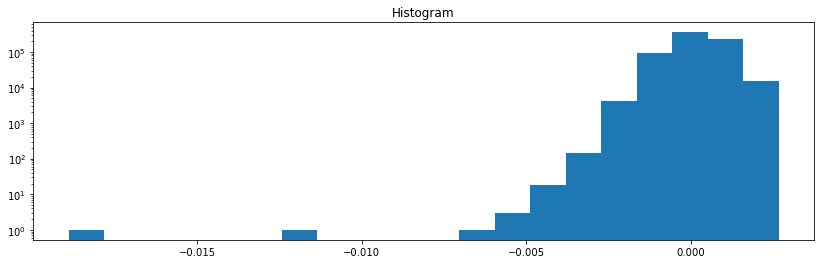

In [11]:
diff.plot.hist(bins=20, log=True, figsize=(14,4),)